# **Dacon 소비자 데이터 기반 소비 예측 경진대회**
- 간단한 데이터 전처리 및 EDA와 Ensemble(Elasticnet, LightGBM, XGBoost) 등의 내용을 포함하고 있습니다.
- 코드실행은 Google Colab의 CPU, Standard RAM 환경에서 진행했습니다.
- 작성자 : standing-o  
(Last modified : 2022.05.06)

## 0. Import Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install folium==0.2.1
!pip install markupsafe==2.0.1
!pip install -U pandas-profiling

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import pandas_profiling
import seaborn as sns
import random as rn
import os
import scipy.stats as stats
import datetime
import calendar

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV, cross_val_score, RepeatedKFold
from sklearn import metrics

from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from collections import Counter
import warnings

%matplotlib inline
warnings.filterwarnings(action='ignore')

In [ ]:
print("numpy version: {}". format(np.__version__))
print("pandas version: {}". format(pd.__version__))
print("matplotlib version: {}". format(matplotlib.__version__))
print("scikit-learn version: {}". format(sklearn.__version__))
print("xgboost version: {}". format(xgb.__version__))
print("lightgbm version: {}". format(lgb.__version__))

numpy version: 1.21.6
pandas version: 1.3.5
matplotlib version: 3.2.2
scikit-learn version: 1.0.2
xgboost version: 0.90
lightgbm version: 2.2.3


In [ ]:
# reproducibility
seed_num = 42   ####
np.random.seed(seed_num)
rn.seed(seed_num)
os.environ['PYTHONHASHSEED']=str(seed_num)

## 1. Load and Check Dataset

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Consumer_spending_forecast/dataset/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Consumer_spending_forecast/dataset/test.csv')

print(train.shape)
train.head()

(1108, 22)


id  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0   0        1974      Master       Together  46014.0        1         1   
1   1        1962  Graduation         Single  76624.0        0         1   
2   2        1951  Graduation        Married  75903.0        0         1   
3   3        1974       Basic        Married  18393.0        1         0   
4   4        1946         PhD       Together  64014.0        2         1   

  Dt_Customer  Recency  NumDealsPurchases  ...  NumStorePurchases  \
0  21-01-2013       21                 10  ...                  8   
1  24-05-2014       68                  1  ...                  7   
2  08-04-2013       50                  2  ...                  9   
3  29-03-2014        2                  2  ...                  3   
4  10-06-2014       56                  7  ...                  5   

   NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  \
0                  7             0             0             0             0   
1                  1             1             0             0             0   
2                  3             0             0             0             0   
3                  8             0             0             0             0   
4                  7             0             0             0             1   

   AcceptedCmp2  Complain  Response  target  
0             0         0         0     541  
1             0         0         0     899  
2             0         0         0     901  
3             0         0         0      50  
4             0         0         0     444  

[5 rows x 22 columns]

In [ ]:
pr = train.profile_report()
pr.to_file('/content/drive/MyDrive/Consumer_spending_forecast/pr_report.html')
pr

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Summary of Pandas profiling : Alert
#### High Correlation
`Income`-`Kidhome`-`NumWebPurchases`-`NumStorePurchases`-`NumStorePurchases`-`NumWebVisitsMonth`-`AcceptedCmp1`-`AcceptedCmp5`-`target`

`NumDealsPurchases`-`Teenhome`

#### High Cardinality
`Dt_customer`
  - ↪ 고객이 회사에 등록한 날짜를 의미하기 때문에 중복도가 낮은 데이터입니다.
--------------------------------
- 📝 Cardinality가 높다 <-> 중복되는 값이 적다

## 2. EDA | Exploratory Data Analysis
- id : 샘플 아이디 | Year_Birth : 고객 생년월일 | Education : 고객 학력
- Marital_status : 고객 결혼 상태 | Income : 고객 연간 가구 소득 | 
- Kidhome : 고객 가구의 자녀 수 | Teenhome : 고객 가구의 청소년 수 | Dt_Customer : 고객이 회사에 등록한 날짜
- Recency : 고객의 마지막 구매 이후 일수 | NumDealsPurchases : 할인된 구매 횟수 | NumWebPurchases : 회사 웹사이트를 통한 구매 건수
- NumCatalogPurchases : 카탈로그를 사용한 구매 수 | NumStorePuchases : 매장에서 직접 구매한 횟수
- NumWebVisitsMonth : 지난 달 회사 웹사이트 방문 횟수
- AcceptedCmp(1-5) : 고객이 (1-5) 번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0
- Complain : 고객이 지난 2년 동안 불만을 제기한 경우 1, 그렇지 않은 경우 0
- Response : 고객이 마지막 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0
- target : 고객의 제품 총 소비량

---------------------

### Data Type
- Numeric (10) : `id`, `Year_Birth`, `Income`, `Recency`, `NumDealsPurchases`, `NumWebPurchases`, `NumCatalogPurchases`, `NumStorePurchases`, `NumWebVisitsMonth`, `target`
- Categorical (12) : `Education`, `Marital_Status`, `Kidhome`, `Teenhome`, `Dt_Customer`, `AcceptedCmp(1~5)`, `Complain`, `Response`
---------------------
- 📝 결측치가 없습니다.

In [ ]:
train.isnull().sum()

id                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Response               0
target                 0
dtype: int64

In [ ]:
test.isnull().sum()

id                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Response               0
dtype: int64

In [ ]:
df_train = train.copy()
df_test = test.copy()

#### 2-(1). Outliers
- 📝 `id`와 `target`을 제외한 numerical 데이터의 outlier 들을 IQR method를 활용하여 찾아줍니다.

In [ ]:
numeric_fts = ['Year_Birth', 'Income', 'Recency', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']

train_outlier_ind = []
for i in numeric_fts:
  Q1 = np.percentile(df_train[i],25)
  Q3 = np.percentile(df_train[i],75)
  IQR = Q3-Q1
  train_outlier_list = df_train[(df_train[i] < Q1 - IQR * 1.5) | (df_train[i] > Q3 + IQR * 1.5)].index
  train_outlier_ind.extend(train_outlier_list)

train_outlier_ind = Counter(train_outlier_ind)
train_multi_outliers = list(k for k,j in train_outlier_ind.items() if j > 2)  

print("The number of train outliers :", len(train_multi_outliers))

The number of train outliers : 0


- 📝 Train 데이터에는 IQR method로 탐지되는 이상치가 없는것을 확인할 수 있습니다.

#### 2-(2). Transformation
- 📝 왜곡된 분포는 모델 학습에 안좋은 영향을 줄 수 있습니다. 높은 skewness를 가지고 있는 `NumDealsPurchases` 변수에 대하여 몇가지 transformation을 진행하려합니다.

In [ ]:
print(df_train[numeric_fts].skew())

Year_Birth            -0.439100
Income                 0.291634
Recency               -0.061310
NumDealsPurchases      2.264245
NumWebPurchases        1.289607
NumCatalogPurchases    1.099499
NumStorePurchases      0.653689
NumWebVisitsMonth      0.299000
dtype: float64


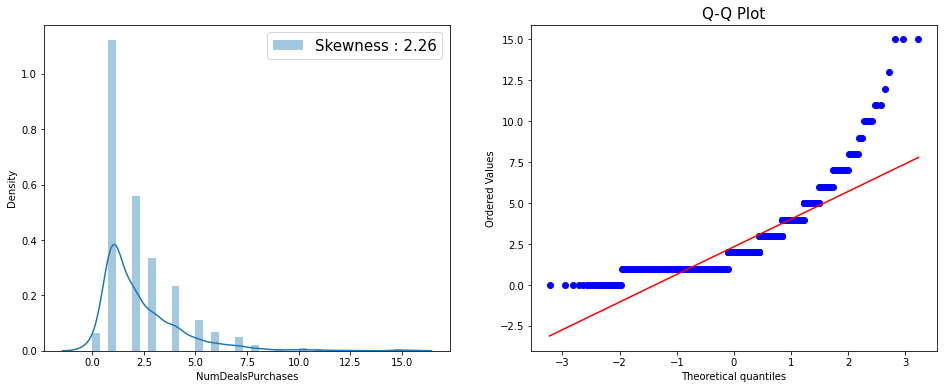

In [ ]:
fig = plt.figure(figsize = (16,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

sns.distplot(df_train['NumDealsPurchases'], ax = ax1, label='Skewness : {:.2f}'.format(df_train['NumDealsPurchases'].skew()))
ax1.legend(loc='best', fontsize = 15)

stats.probplot(df_train['NumDealsPurchases'], plot = ax2)
plt.title("Q-Q Plot", fontsize = 15)
plt.show()

#### Log transformation

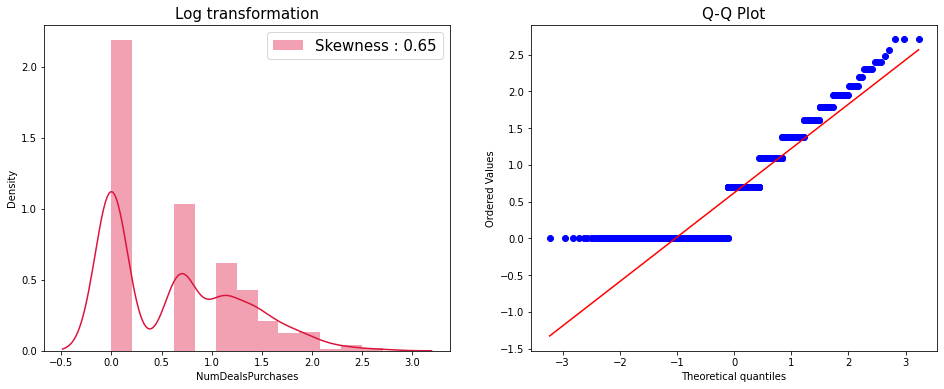

In [ ]:
log_trans = df_train['NumDealsPurchases'].map(lambda i: np.log(i) if i > 0 else 0)

fig = plt.figure(figsize = (16,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

sns.distplot(log_trans, ax = ax1, color='crimson', label='Skewness : {:.2f}'.format(log_trans.skew()))
ax1.legend(loc='best', fontsize = 15)
ax1.set_title('Log transformation', fontsize = 15)

stats.probplot(log_trans, plot = ax2)
ax2.set_title("Q-Q Plot", fontsize = 15)
plt.show()

#### Yeo-Johnson transformation

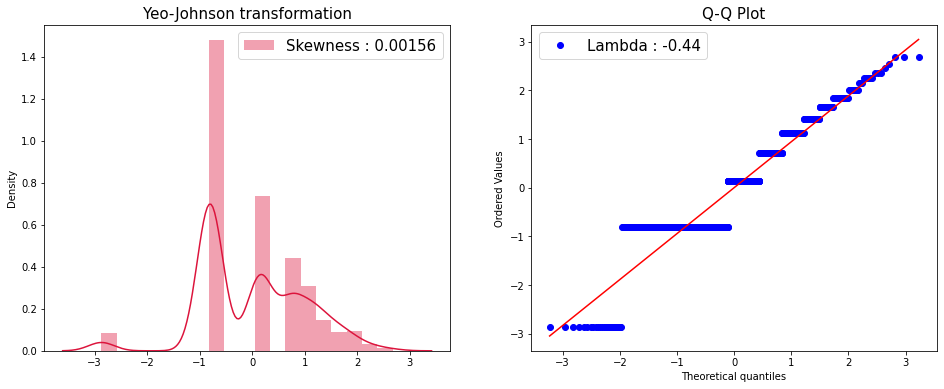

In [ ]:
jy = PowerTransformer(method = 'yeo-johnson')
jy.fit(df_train['NumDealsPurchases'].values.reshape(-1, 1))
x_yj = jy.transform(df_train['NumDealsPurchases'].values.reshape(-1, 1))

fig = plt.figure(figsize = (16,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

sns.distplot(x_yj, ax = ax1, color='crimson', label='Skewness : {:.5f}'.format(np.float(stats.skew(x_yj))))
ax1.legend(loc='best', fontsize = 15)
ax1.set_title('Yeo-Johnson transformation', fontsize = 15)

stats.probplot(x_yj.reshape(x_yj.shape[0]), plot = ax2)
ax2.legend(['Lambda : {:.2f}'.format(np.float(jy.lambdas_))], loc='best', fontsize = 15)
ax2.set_title("Q-Q Plot", fontsize = 15)
plt.show()

- 📝 두 변환을 진행한 결과 모두 조금 더 정규분포 직선과 비슷해진것을 Q-Q Plot을 통해 확인할 수 있습니다.
- 📝 데이터 전처리에는 Yeo-Johnson transformation을 사용했습니다.

In [ ]:
df_train['NumDealsPurchases'] = x_yj
df_train['NumDealsPurchases'].head()

0    2.258975
1   -0.801066
2    0.146388
3    0.146388
4    1.846930
Name: NumDealsPurchases, dtype: float64

In [ ]:
test_jy = PowerTransformer(method = 'yeo-johnson')
test_jy.fit(df_test['NumDealsPurchases'].values.reshape(-1, 1))
test_x_yj = test_jy.transform(df_test['NumDealsPurchases'].values.reshape(-1, 1))
df_test['NumDealsPurchases'] = test_x_yj

### 2-(3). Correlation
- 📝 앞서 수행한 pandas profiling report의 alert를 참고하여 상관계수를 계산했습니다.

In [ ]:
corr_fts1 = ['Income', 'Kidhome', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp1', 'AcceptedCmp5', 'target']
corr_fts2 = ['NumDealsPurchases', 'Teenhome']

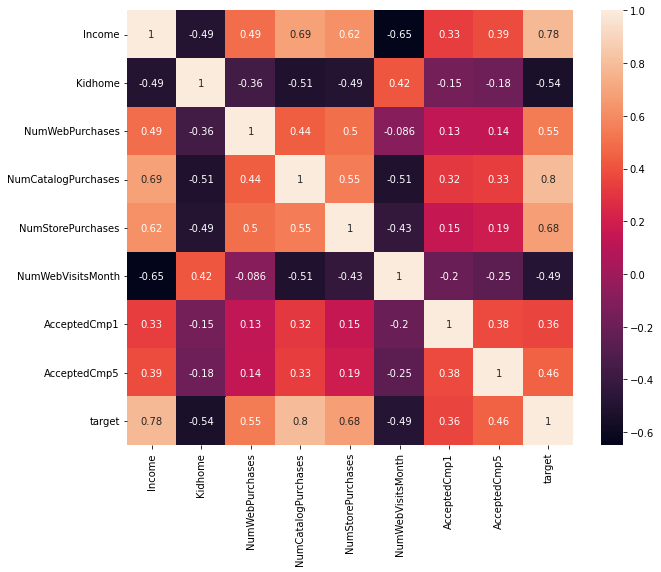

In [ ]:
plt.figure(figsize = (10,8))
sns.heatmap(df_train[corr_fts1].corr(), annot=True)

plt.show()

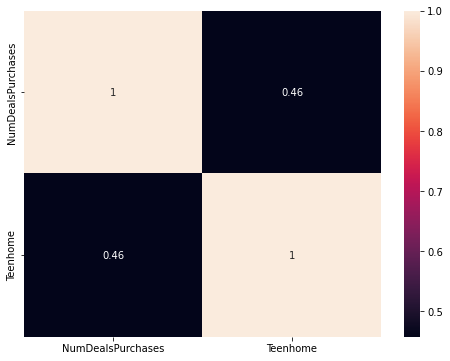

In [ ]:
plt.figure(figsize = (8,6))
sns.heatmap(df_train[corr_fts2].corr(), annot=True)

plt.show()

- 📝 독립변수 간의 높은 상관관계는 다중공선성을 유발하기 때문에 좋지 않습니다.
- 📝 위 문제는 변수 선택, 차원 축소, 규제 등의 방법으로 해결할 수 있고, 저는 모델에 규제를 적용하거나 다중공선성의 영향을 적게 받는다고 생각되는 Decision Tree 베이스의 모델을 사용 할 예정입니다.

In [ ]:
train_dataset = df_train.copy()
test_dataset = df_test.copy()

## 3. Feature Engineering

#### 3-(1) `Dt_Customer` 변수 : 날짜 데이터 다루기
- 📝 `Dt_Customer` 변수는 회사 등록일을 뜻합니다. 회사에 등록한 시점에 대한 정보를 유지하면서 모델링에 사용할 수 있는 새 수치형 변수를 만들려고합니다.  
↪ 가장 과거 시점의 회사 등록일로부터 며칠이 지났는지를 뜻하는 `Pass_Customer`변수를 새롭게 생성합니다. 

In [ ]:
train_dataset["Dt_Customer"]

0       21-01-2013
1       24-05-2014
2       08-04-2013
3       29-03-2014
4       10-06-2014
           ...    
1103    31-03-2013
1104    21-10-2013
1105    16-12-2013
1106    30-05-2013
1107    29-10-2012
Name: Dt_Customer, Length: 1108, dtype: object

In [ ]:
train_dataset["Dt_Customer"] = pd.to_datetime(train_dataset["Dt_Customer"], format='%d-%m-%Y')
test_dataset["Dt_Customer"] = pd.to_datetime(test_dataset["Dt_Customer"], format='%d-%m-%Y')

train_dataset["Dt_Customer"]

0      2013-01-21
1      2014-05-24
2      2013-04-08
3      2014-03-29
4      2014-06-10
          ...    
1103   2013-03-31
1104   2013-10-21
1105   2013-12-16
1106   2013-05-30
1107   2012-10-29
Name: Dt_Customer, Length: 1108, dtype: datetime64[ns]

In [ ]:
print(f'Minimum date: {train_dataset["Dt_Customer"].min()}')
print(f'Maximum date: {train_dataset["Dt_Customer"].max()}')

Minimum date: 2012-07-31 00:00:00
Maximum date: 2014-06-29 00:00:00


In [ ]:
train_diff_date = train_dataset["Dt_Customer"] - train_dataset["Dt_Customer"].min()
test_diff_date = test_dataset["Dt_Customer"] - test_dataset["Dt_Customer"].min()

train_dataset["Pass_Customer"] = [i.days for i in train_diff_date]
test_dataset["Pass_Customer"] = [i.days for i in test_diff_date]

In [ ]:
train_dataset["Pass_Customer"].head()

0    174
1    662
2    251
3    606
4    679
Name: Pass_Customer, dtype: int64

#### 3-(2) `Year_Birth` to `Age`
- 📝 `Year_Birth` 변수를 활용하여 고객의 나이를 뜻하는 `Age` 변수를 새롭게 생성했습니다.
- 📝 한국나이로 계산했습니다.

In [ ]:
print("Minimum birth :", train_dataset["Year_Birth"].min(), "\nMaximum birth :", train_dataset["Year_Birth"].max(), "\n")
train_dataset["Year_Birth"].head()

Minimum birth : 1893 
Maximum birth : 1996 



0    1974
1    1962
2    1951
3    1974
4    1946
Name: Year_Birth, dtype: int64

In [ ]:
train_dataset["Age"] = 2022 - train_dataset["Year_Birth"] + 1
test_dataset["Age"] = 2022 - test_dataset["Year_Birth"] + 1

train_dataset["Age"].head()

0    49
1    61
2    72
3    49
4    77
Name: Age, dtype: int64

#### 3-(3) `AcceptedCmp(1~5)` 와 `Response` 변수로 새 Feature 생성
- 📝 위 여섯개의 변수는 고객이 1~5 번째와 마지막 캠페인에서 제안을 수락한 경우 1, 아닌경우 0 값을 가집니다.   
이 변수들을 활용하여 캠페인에서 제안을 수락한 횟수를 나타내는 `AcceptCount` 변수를 새롭게 생성하겠습니다.

In [ ]:
train_dataset["AcceptCount"] = train_dataset["AcceptedCmp1"] + train_dataset["AcceptedCmp2"] + train_dataset["AcceptedCmp3"] + train_dataset["AcceptedCmp4"] + train_dataset["AcceptedCmp5"] + train_dataset["Response"]
test_dataset["AcceptCount"] = test_dataset["AcceptedCmp1"] + test_dataset["AcceptedCmp2"] + test_dataset["AcceptedCmp3"] + test_dataset["AcceptedCmp4"] + test_dataset["AcceptedCmp5"] + test_dataset["Response"]

train_dataset["AcceptCount"].head()

0    0
1    1
2    0
3    0
4    1
Name: AcceptCount, dtype: int64

In [ ]:
print("Minimum count :", train_dataset["AcceptCount"].min(), "\nMaximum count :", train_dataset["AcceptCount"].max(), "\n")

Minimum count : 0 
Maximum count : 5 



- 📝 train 데이터에서 캠페인 제안을 여섯번 모두 수락한 경우는 없는것을 확인할 수 있습니다.

- 📝 원래의 변수와 `target`과의 상관관계를 확인하겠습니다.

In [ ]:
train_dataset[['Year_Birth', 'AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5', 'Response','target']].corr()

Year_Birth  AcceptedCmp1  AcceptedCmp2  AcceptedCmp3  \
Year_Birth      1.000000     -0.050053     -0.034204      0.066802   
AcceptedCmp1   -0.050053      1.000000      0.198530      0.052213   
AcceptedCmp2   -0.034204      0.198530      1.000000      0.052513   
AcceptedCmp3    0.066802      0.052213      0.052513      1.000000   
AcceptedCmp4   -0.111485      0.184717      0.328941     -0.083690   
AcceptedCmp5   -0.010873      0.379563      0.192139      0.060890   
Response       -0.012304      0.268577      0.201945      0.194275   
target         -0.136035      0.361102      0.129995      0.040736   

              AcceptedCmp4  AcceptedCmp5  Response    target  
Year_Birth       -0.111485     -0.010873 -0.012304 -0.136035  
AcceptedCmp1      0.184717      0.379563  0.268577  0.361102  
AcceptedCmp2      0.328941      0.192139  0.201945  0.129995  
AcceptedCmp3     -0.083690      0.060890  0.194275  0.040736  
AcceptedCmp4      1.000000      0.313120  0.189849  0.256784  
AcceptedCmp5      0.313120      1.000000  0.336610  0.458208  
Response          0.189849      0.336610  1.000000  0.242760  
target            0.256784      0.458208  0.242760  1.000000

In [ ]:
# Dt_customer
year = pd.to_datetime(train_dataset["Dt_Customer"]).dt.year
month = pd.to_datetime(train_dataset["Dt_Customer"]).dt.month
day = pd.to_datetime(train_dataset["Dt_Customer"]).dt.day

print(np.corrcoef(year, train_dataset['target']), '\n')
print(np.corrcoef(month, train_dataset['target']), '\n')
print(np.corrcoef(day, train_dataset['target']))

[[ 1.         -0.15940385]
 [-0.15940385  1.        ]] 

[[1.         0.03764911]
 [0.03764911 1.        ]] 

[[1.         0.01891694]
 [0.01891694 1.        ]]


- 📝 새로 생성한 변수와 `target`과의 상관관계를 확인하겠습니다.

In [ ]:
train_dataset[['Pass_Customer', 'Age', 'AcceptCount', 'target']].corr()

Pass_Customer       Age  AcceptCount    target
Pass_Customer       1.000000  0.012309    -0.080152 -0.174969
Age                 0.012309  1.000000     0.043180  0.136035
AcceptCount        -0.080152  0.043180     1.000000  0.444114
target             -0.174969  0.136035     0.444114  1.000000

- 📝 정리하자면, `Pass_Customer`-`target`의 상관계수 절댓값이 `Dt_Customer`(`year`, `month`, `day`)-`target` 보다 조금 더 크다는 것을 확인할 수 있습니다.
- 📝 또한, 당연하게도 `Year_Birth`를 `Age` 변수로 바꾼것은 상관관계에 아무런 영향도 주지 못했습니다.
- 📝 `AcceptCount`는 `target`과 어느정도 상관관계가 있습니다.


In [ ]:
train_data = train_dataset.copy()
test_data = test_dataset.copy()

## 4. One-Hot Encoding
- 📝 `Education`, `Marital_Status` 변수의 one-hot encoding을 진행했습니다.

In [ ]:
drop_col = ['id', 'Dt_Customer', 'Year_Birth', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']

train_data = train_data.drop(drop_col, axis = 1)
test_data = test_data.drop(drop_col, axis = 1)

In [ ]:
print(train_data['Education'].unique())
print(train_data['Marital_Status'].unique())

['Master' 'Graduation' 'Basic' 'PhD' '2n Cycle']
['Together' 'Single' 'Married' 'Widow' 'Divorced' 'Alone' 'YOLO' 'Absurd']


In [ ]:
# One-hot encoding
train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)

print(train_data.columns)
print(test_data.columns)

Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'Complain', 'target', 'Pass_Customer', 'Age',
       'AcceptCount', 'Education_2n Cycle', 'Education_Basic',
       'Education_Graduation', 'Education_Master', 'Education_PhD',
       'Marital_Status_Absurd', 'Marital_Status_Alone',
       'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Together',
       'Marital_Status_Widow', 'Marital_Status_YOLO'],
      dtype='object')
Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'Complain', 'Pass_Customer', 'Age', 'AcceptCount',
       'Education_2n Cycle', 'Education_Basic', 'Education_Graduation',
       'Education_Master', 'Education_PhD', 'Marital_Status_Absurd',
       'Marital_Status_Alone', 'Marital

In [ ]:
print("Length of train column :", len(train_data.columns))
print("Length of test column :", len(test_data.columns))

Length of train column : 27
Length of test column : 26


- 📝 train 데이터의 `target` 컬럼을 제외하고는 train과 test의 열길이가 같도록 one-hot encoding이 잘 진행된것을 확인할 수 있습니다.

In [ ]:
train_data.head()

Income  Kidhome  Teenhome  Recency  NumDealsPurchases  NumWebPurchases  \
0  46014.0        1         1       21           2.258975                7   
1  76624.0        0         1       68          -0.801066                5   
2  75903.0        0         1       50           0.146388                6   
3  18393.0        1         0        2           0.146388                3   
4  64014.0        2         1       56           1.846930                8   

   NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  Complain  ...  \
0                    1                  8                  7         0  ...   
1                   10                  7                  1         0  ...   
2                    6                  9                  3         0  ...   
3                    0                  3                  8         0  ...   
4                    2                  5                  7         0  ...   

   Education_Master  Education_PhD  Marital_Status_Absurd  \
0                 1              0                      0   
1                 0              0                      0   
2                 0              0                      0   
3                 0              0                      0   
4                 0              1                      0   

   Marital_Status_Alone  Marital_Status_Divorced  Marital_Status_Married  \
0                     0                        0                       0   
1                     0                        0                       0   
2                     0                        0                       1   
3                     0                        0                       1   
4                     0                        0                       0   

   Marital_Status_Single  Marital_Status_Together  Marital_Status_Widow  \
0                      0                        1                     0   
1                      1                        0                     0   
2                      0                        0                     0   
3                      0                        0                     0   
4                      0                        1                     0   

   Marital_Status_YOLO  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  

[5 rows x 27 columns]

## 5. Modeling
- 📝 train x 데이터와 target 데이터를 나눠줍니다.

In [ ]:
train_x = train_data.drop('target', axis = 1)
train_y = pd.DataFrame(train_data['target'])

In [ ]:
def nmae(true, pred):
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score

- 📝 Lasso, Ridge regression은 Linear regression에 규제를 적용하는 방법입니다. 저는 이 두 모델의 규제를 모두 적용할 수 있는 **Elastic-Net**을 사용했습니다.
- 📝 또한 **LightGBM, XGBoost** 모델을 사용했고, 최종적으로 세 모델을 활용하여 **Ensemble**을 진행했습니다.

### Elastic-Net

In [ ]:
ela_param_grid = {'alpha': np.arange(1e-4,1e-3,1e-4),
              'l1_ratio': np.arange(0.1,1.0,0.1),
              'max_iter':[100000]}

elasticnet = ElasticNet(random_state = seed_num)

ela_rkfold = RepeatedKFold(n_splits = 5, n_repeats = 5, random_state = seed_num)
ela_gsearch = GridSearchCV(elasticnet, ela_param_grid, cv = ela_rkfold, scoring='neg_mean_absolute_error',
                               verbose=1, return_train_score=True)

In [ ]:
ela_gsearch.fit(train_x, train_y)

Fitting 25 folds for each of 81 candidates, totalling 2025 fits


GridSearchCV(cv=RepeatedKFold(n_repeats=5, n_splits=5, random_state=42),
             estimator=ElasticNet(random_state=42),
             param_grid={'alpha': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'max_iter': [100000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [ ]:
elasticnet = ela_gsearch.best_estimator_        
ela_grid_results = pd.DataFrame(ela_gsearch.cv_results_)  
ela_pred = elasticnet.predict(train_x)

In [ ]:
print("train nmae of elasticnet :", nmae(train_y.values, ela_pred))

train nmae of elasticnet : 1.0457572302381468


### XGBoost

In [ ]:
xgb = XGBRegressor(objective='reg:squarederror', random_state = seed_num)

xgb_param_grid = {'n_estimators':np.arange(100,500,100),
              'max_depth':[1,2,3],
             }

xgb_rkfold = RepeatedKFold(n_splits = 5, n_repeats = 1, random_state = seed_num)
xgb_gsearch = GridSearchCV(xgb, xgb_param_grid, cv = xgb_rkfold, scoring='neg_mean_absolute_error',
                               verbose=1, return_train_score=True)

In [ ]:
xgb_gsearch.fit(train_x, train_y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=5, random_state=42),
             estimator=XGBRegressor(objective='reg:squarederror',
                                    random_state=42),
             param_grid={'max_depth': [1, 2, 3],
                         'n_estimators': array([100, 200, 300, 400])},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [ ]:
xgb = xgb_gsearch.best_estimator_        
xgb_grid_results = pd.DataFrame(xgb_gsearch.cv_results_)  
xgb_pred = xgb.predict(train_x)

print("train nmae of xgb :", nmae(train_y.values, xgb_pred))

train nmae of xgb : 1.0603134393578721


### LightGBM

In [ ]:
lgbm = LGBMRegressor(objective='regression', random_state = seed_num)

lgbm_param_grid = {'n_estimators': [8,16,24], 'num_leaves': [6,8,12,16], 'reg_alpha' : [1,1.2], 'reg_lambda' : [1,1.2,1.4]}


lgbm_rkfold = RepeatedKFold(n_splits = 5, n_repeats = 1, random_state = seed_num)
lgbm_gsearch = GridSearchCV(lgbm, lgbm_param_grid, cv = lgbm_rkfold, scoring='neg_mean_absolute_error',
                               verbose=1, return_train_score=True)

In [ ]:
lgbm_gsearch.fit(train_x, train_y)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=5, random_state=42),
             estimator=LGBMRegressor(objective='regression', random_state=42),
             param_grid={'n_estimators': [8, 16, 24],
                         'num_leaves': [6, 8, 12, 16], 'reg_alpha': [1, 1.2],
                         'reg_lambda': [1, 1.2, 1.4]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [ ]:
lgbm = lgbm_gsearch.best_estimator_        
lgbm_grid_results = pd.DataFrame(lgbm_gsearch.cv_results_)  
lgbm_pred = lgbm.predict(train_x)

print("train nmae of lgbm :", nmae(train_y.values, lgbm_pred))

train nmae of lgbm : 1.0075199760582296


### Blending Models - Ensemble

In [ ]:
def blended_models(X):
    return ((elasticnet.predict(X)) + (xgb.predict(X)) + (lgbm.predict(X)))/3

In [ ]:
blended_score = nmae(train_y.values, blended_models(train_x))
print('train nmae of blended model:', blended_score)

train nmae of blended model: 1.0298941681188711


추가적으로 계속 모델의 성능을 향상시켜볼 예정입니다.
#### **감사합니다 :)**
도움이 됐길 바랍니다👍👍